<a href="https://colab.research.google.com/github/mabonmn/Image_features_and_probablilty/blob/main/Master_Colab_For_SingleImage_Features_P6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Colab is intended to be used for single frames/images. This colab is capable of classifiying images and producing features for 3 main models, ie 

> GoogLeNet: pytorch/vision:v0.10.0 from pytorch

> ResNet: resnet152 from pytorch

> Clip 'RN50' from https://github.com/openai/CLIP.git

#Packages

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
import torch
import clip
import torch.nn as nn
from torchvision import models
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fj8h0sf6
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-fj8h0sf6
     |████████████████████████████████| 53 kB 1.1 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369328 sha256=2fc9beb60a9d1c9d9300e59d23dbeb45154903452744e1b2a4d8edf81ab48be9
  Stored in directory: /tmp/pip-ephem-wheel-cache-565jfvvw/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]   
 

--2022-04-19 18:47:42--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-04-19 18:47:42 (87.1 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



#Input Image

In [ ]:
#Sample Image
!gdown --id 1tdIiGtBxQ5gOouiN6Jcuy7L6VEtBjlO3

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1tdIiGtBxQ5gOouiN6Jcuy7L6VEtBjlO3
To: /content/0.png
100% 215k/215k [00:00<00:00, 88.9MB/s]


In [ ]:
image_path="/content/0.png"

In [ ]:
input_image=Image.open(image_path)

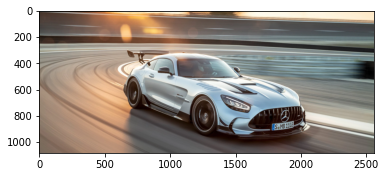

In [ ]:
plt.imshow(input_image)

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#Models

##GoogLeNet

In [ ]:
model1 = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model1.eval()
print(" ")


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
model2= torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model2 = nn.Sequential(*list(model2.children())[:-1])
model2.eval()
print(" ")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model1.to('cuda')
    model2.to('cuda')

    
with torch.no_grad():
    #For Prob:
    output = model1(input_batch)

    #For Features:
    major_output = model2(input_batch)
    features1=major_output[0].view(-1).numpy()

#frame prob using recomended extration from torch.hub
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob1, top5_catid1 = torch.topk(probabilities, 5)

top5_prob1=np.array(top5_prob1)
top5_catid1=np.array(top5_catid1)

###Result:GoogLeNet

###Probabilities

In [ ]:
print("GOOGLENET: ")
for j in range(5):
    print(categories[(top5_catid1)[j]]+" : "+str(((top5_prob1)[j]*100)))


GOOGLENET: 
sports car : 43.96614134311676
racer : 11.195775866508484
beach wagon : 6.392101943492889
car wheel : 5.905703827738762
limousine : 5.380546674132347


###Features

In [ ]:
print("Features: ")
print(pd.DataFrame(features1))
#For Saving Features
#features1.to_csv(index=False)

Features: 
             0
0     0.765481
1     0.131216
2     0.161687
3     0.010697
4     0.001131
...        ...
1019  1.073602
1020  0.175030
1021  0.221760
1022  0.007006
1023  0.145207

[1024 rows x 1 columns]


##Resnet

In [ ]:
model3=models.resnet152(pretrained=True)
model3.eval()
print(" ")

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
model4=models.resnet152(pretrained=True)
model4 = nn.Sequential(*list(model4.children())[:-1])
model4.eval()
print(" ")

In [ ]:
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model3.to('cuda')
    model4.to('cuda')

    
with torch.no_grad():
    output = model3(input_batch)
    major_output = model4(input_batch)
    features2=major_output[0].view(-1).numpy()
#frame prob using recomended extration from torch.hub
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob2, top5_catid2 = torch.topk(probabilities, 5)
top5_prob2=np.array(top5_prob2)
top5_catid2=np.array(top5_catid2)

###Result: ResNet

###Probabilities

In [ ]:
print("ResNet: ")
for j in range(5):
    print(categories[(top5_catid2)[j]]+" : "+str(((top5_prob2)[j]*100)))


ResNet: 
sports car : 72.94265031814575
racer : 17.385263741016388
grille : 3.485378995537758
car wheel : 2.780708484351635
cab : 1.1968383565545082


###Features

In [ ]:
print("Features: ")
print(pd.DataFrame(features2))
#For Saving Features
#features2.to_csv(index=False)

Features: 
             0
0     0.752426
1     0.321645
2     0.094134
3     0.149049
4     0.201785
...        ...
2043  0.373989
2044  0.152276
2045  0.299945
2046  0.160176
2047  0.110946

[2048 rows x 1 columns]


##Clip

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model5, preprocess_clip = clip.load('RN50', device)             #We use RN50 since it has features shapr pf 1*1024 which is the same as GoogLeNet

100%|███████████████████████████████████████| 244M/244M [00:02<00:00, 93.6MiB/s]


In [ ]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in categories]).to(device)
with torch.no_grad():
  text_features = model5.encode_text(text_inputs)

In [ ]:
image_input = preprocess_clip(input_image).unsqueeze(0).to(device)
# Calculate features
with torch.no_grad():
  image_features = model5.encode_image(image_input)
  features3=model5.encode_image(image_input).detach().cpu().numpy()
features3=np.array(features3)
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
probabilities = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top5_prob3, top5_catid3 = probabilities[0].topk(5)
top5_prob3=np.array(top5_prob2)
top5_catid3=np.array(top5_catid2)

###Result:Clip

###Probabilities

In [ ]:
print("CLIP: ")
for j in range(5):
    print(categories[(top5_catid3)[j]]+" : "+str(((top5_prob3)[j]*100)))


CLIP: 
sports car : 72.94265031814575
racer : 17.385263741016388
grille : 3.485378995537758
car wheel : 2.780708484351635
cab : 1.1968383565545082


###Features

In [ ]:
print("Features: ")
print(pd.DataFrame(features3))
#For Saving Features
#features3.to_csv(index=False)

Features: 
       0         1         2         3         4         5         6     \
0 -0.011779  0.038902 -0.053396  0.006868  0.069593  0.038028  0.049727   

       7         8         9     ...      1014      1015      1016      1017  \
0 -0.020445  0.002813 -0.547005  ... -0.075384  0.005353 -0.023544 -0.020216   

       1018      1019      1020     1021      1022      1023  
0  0.003445  0.008974  0.101361  0.07459  0.012182  0.127032  

[1 rows x 1024 columns]
